In [60]:
import keras
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [61]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import glob
# import skimage.io
# from tqdm import tqdm 
from skimage.io import imread, imshow
# from skimage.transform import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
%matplotlib inline

In [62]:
### IMPORT DATASET

In [63]:
train_o = glob.glob('Waste_DATASET/TRAIN/O/*.jpg')
train_r = glob.glob('Waste_DATASET/TRAIN/R/*.jpg')

In [64]:
#### DATA AUGMENTATION

In [65]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

train_dataset  = train_datagen.flow_from_directory(directory = 'Waste_DATASET/TRAIN',
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 64, 
                                                   subset = 'training')

valid_dataset = valid_datagen.flow_from_directory(directory = 'Waste_DATASET/TRAIN',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 64, 
                                                  subset = 'validation')

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.


In [66]:
# Class Indices 
class_indices = train_dataset.class_indices

In [67]:
### MODEL BUILDING

In [4]:
# Defining Model
base_model = VGG16(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

# Freezing Layers 
for layer in base_model.layers:
    layer.trainable=False
    
# Defining Layers
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

# Summary
base_model.summary()    

# Model Compile 
OPT    = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

# Defining Callbacks
filepath = './best_weights.hdf5'
earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 5,
                              verbose = 1)
checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

callback_list = [earlystopping, checkpoint]

# Model Fitting 
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 20,
                        callbacks = callback_list,
                        verbose = 1)

NameError: name 'VGG16' is not defined

In [1]:
### MODEL EVALUATION

In [2]:
# Summarize the model loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('VGG16 Model Loss', FontSize = 16)
plt.ylabel('Loss', FontSize = 16)
plt.xlabel('Epoch', FontSize = 16)
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

NameError: name 'plt' is not defined

In [3]:
# Summarize models auc
plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('VGG16 Model Accuracy', FontSize = 16)
plt.ylabel('Accuracy',FontSize = 16)
plt.xlabel('Epoch',FontSize = 16)
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

NameError: name 'plt' is not defined

In [190]:
max(model_history.history['auc']), max(model_history.history['val_auc'])

(0.9691686034202576, 0.9562782049179077)

In [191]:
# load model 
from keras.models import Model,load_model
model = load_model('best_weights.hdf5')
model.load_weights('best_weights.hdf5')

In [192]:
# load test dataset 
test_R = glob.glob(r'Waste_DATASET/TEST/R/*.*')
test_O = glob.glob(r'Waste_DATASET/TEST/O/*.*')

test_data = []
test_labels = []

# {'O': 0, 'R': 1}
for i in test_O:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    test_data.append(image)
    test_labels.append(0)
    
for i in test_R:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    test_data.append(image)
    test_labels.append(1)
    
test_data = np.array(test_data)
test_labels = np.array(test_labels)    

In [193]:
# predict crisp classes for test set
yhat_classes = model.predict_classes(test_data, verbose=0)

/projects/227b4fde-cdd9-4dcf-987f-8b1cf00b412b/miniconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [194]:
# reduce to 1d array
yhat_classes = yhat_classes[:, 0]

In [195]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, cohen_kappa_score, roc_auc_score, confusion_matrix

testy = test_labels
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testy, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testy, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testy, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy, yhat_classes)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(testy, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(testy, yhat_classes)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(testy, yhat_classes)
print(matrix)

Accuracy: 0.840430
Precision: 0.821138
Recall: 0.817446
F1 score: 0.819288
Cohens kappa: 0.676432
ROC AUC: 0.838059
[[1203  198]
 [ 203  909]]


[[1203  198]
 [ 203  909]]


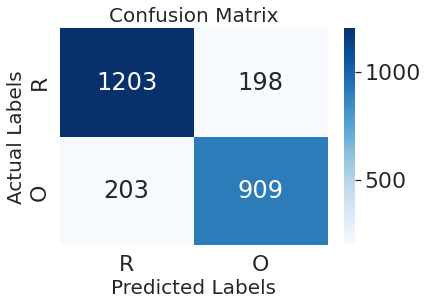

In [196]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
## Create the Confusion Matrix out of the Actual and Predicted Data.
cm = confusion_matrix(test_labels , yhat_classes)
# scale the font size and color of the map
ax = sns.set(font_scale=2) #edited as suggested
ax = sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");  # annot=True to annotate cells
## Print the Confusion Matrix
print(cm)
ax.set_title('Confusion Matrix', size=20);
ax.set_xlabel('Predicted Labels',size=20)
ax.set_ylabel('Actual Labels', size=20);
ax.xaxis.set_ticklabels(['R', 'O']); 
ax.yaxis.set_ticklabels(['R', 'O']);

/projects/227b4fde-cdd9-4dcf-987f-8b1cf00b412b/miniconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


The probability of being Recycle is 5.61%
The probability of being Organic is 94.39%
The image belongs to Organic waste category 


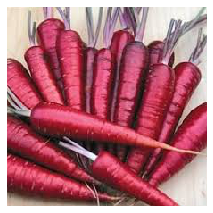

In [91]:
# Test Case:1 - ORGANIC

# dic = test_data.class_indices
# idc = {k:v for v,k in dic.items()}

img = load_img('Waste_DATASET/TEST/O/O_12650.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_proba(img)

# print(answer)

print("The probability of being Recycle is {:.2f}%".format(answer[0][0]*100))
print("The probability of being Organic is {:.2f}%".format((1-answer[0][0])*100))

if answer[0][0] > 0.5:
    print("The image belongs to Recycle waste category")
else:
    print("The image belongs to Organic waste category ")